In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import os
import random

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook

In [2]:
results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_all_stimuli_10ms_bins_0/"

In [3]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.268.csv"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_engaged'),
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [4]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    # 'unit_criteria',
}

#toggle keep_original_structure
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)

# map structures to grouped structures
# SCop, SCsg, SCzo -> SCs
# SCig, SCiw, SCdg, SCdw -> SCm
# ECT1, ECT2/3, ECT6b, ECT5, ECT6a, ECT4 -> ECT
structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}


In [ ]:
#### need to change this to get predict_proba for each stimulus!

In [5]:
# get result-wise predict proba dataframes

# def get_predict_proba_results_df(results_path, grouping_cols, combine_multi_probe_expr, n_repeats, structure_grouping, predict_proba_alias='predict_proba'):

structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

predict_proba_wo_repeats = (
    pl.scan_parquet(results_path)
    #make new column that indicates whether a row is the sole recording from a structure in a session
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
    )
    #Grab only rows according to combine_multi_probe_rec toggle
    #Grab only rows that have is_all_trials == True, only these have predict_proba
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
    )
    #join on the units table to get total number of units per structure
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            #make new rows according to structure_grouping
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                .then(pl.col('structure').repeat_by(n_repeats))
                .otherwise(pl.col('structure').repeat_by(1))
            )
            .explode('structure')
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                .then(pl.col('structure').replace(structure_grouping))
                .otherwise(pl.col('structure'))
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='left',
    )
    .with_columns(
        #pl.int_ranges(0, pl.col(predict_proba_alias).list.len()).alias('trial_index')
        pl.col('trial_indices').alias('trial_index')
    )
    .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording')
    .explode('predict_proba_vis1', 'predict_proba_vis2', 'predict_proba_sound1', 'predict_proba_sound2', 'trial_index')
    .group_by('session_id', 'structure', 'unit_subsample_size', 'trial_index', 'bin_center', 'bin_size', 'time_aligned_to',)
    .agg(
        pl.col('balanced_accuracy_test').mean(),
        pl.col('predict_proba_vis1').mean(),
        pl.col('predict_proba_vis2').mean(),
        pl.col('predict_proba_sound1').mean(),
        pl.col('predict_proba_sound2').mean(),
        pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
    )
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
                #iti column?
            )
            .select('session_id', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response')
        ),
        on=['session_id','trial_index'],
        how='inner',
    ) 
    .group_by('session_id', 'structure', 'unit_subsample_size', 'bin_center', 'time_aligned_to',)
    .agg(
        pl.col('balanced_accuracy_test').first(),
        pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
        pl.col('predict_proba_vis1', 'predict_proba_vis2', 'predict_proba_sound1', 'predict_proba_sound2', 
               'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response').sort_by('trial_index'),

    )
    .sort('session_id','structure', 'unit_subsample_size', 'bin_center')
    # .group_by('session_id','structure')
    .collect(engine='streaming')
)

    # return predict_proba_wo_repeats.to_pandas()

In [7]:
predict_proba_pd=predict_proba_wo_repeats.to_pandas()

In [ ]:
def get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to):
    """
    Get the results for a specific session and structure.
    """

    if sel_unit_subsample_size=='all':
        example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                    time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size.isna()'
                                                    ).sort_values('bin_center').reset_index(drop=True)
    else:
        example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                    time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}'
                                                    ).sort_values('bin_center').reset_index(drop=True)
    #get context switches
    is_context_switch=np.concatenate([[0],np.diff(example_area_results['is_vis_rewarded'].iloc[0])]).astype(bool)
    context_switch_list=[]
    for rr in range(len(example_area_results)):
        context_switch_list.append(is_context_switch)
    example_area_results['is_context_switch']=context_switch_list


    return example_area_results

In [48]:
#get predict_proba for different trial types, make new table

# sel_session="664851_2023-11-13"
# sel_structure="SCm"
sel_unit_subsample_size='all'
sel_time_aligned_to='stim_start_time'

all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/performance.parquet').collect().to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet').collect().to_pandas()

trial_type_table={
    'session_id':[],
    'structure':[],
    'predict_proba_vis1':[],
    'predict_proba_vis2':[],
    'predict_proba_sound1':[],
    'predict_proba_sound2':[],
    'bin_centers':[],
    'unit_subsample_size':[],
    'time_aligned_to':[],
    'trial_index':[],
    'is_response':[],
    'is_vis_rewarded':[],
    'stim_name':[],
    'n_trials':[],
    'session_dprime':[],
    'n_passing_vis_blocks':[],
    'n_passing_aud_blocks':[],
}

stimuli=['vis1', 'vis2', 'sound1', 'sound2']

for sel_session in predict_proba_pd['session_id'].unique():
    if sel_session not in dr_session_list:
        print(f"session {sel_session} not in dr_session_list; skipping")
        continue
    
    session_performance=all_performance.query(f'session_id=="{sel_session}"')
    session_dprime=session_performance['cross_modality_dprime'].mean()
    n_passing_vis_blocks=session_performance.query('rewarded_modality=="vis" and cross_modality_dprime>1').shape[0]
    n_passing_aud_blocks=session_performance.query('rewarded_modality=="aud" and cross_modality_dprime>1').shape[0]
    session_trials=all_trials.query(f'session_id=="{sel_session}"')

    for sel_structure in predict_proba_pd.query('session_id==@sel_session')['structure'].unique():

        #get session-structure results
        example_area_results=get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)
        
        #these are the indices of trials with data (i.e. for response aligned trials)
        trial_index=example_area_results['trial_index'].iloc[0]

        #loop through type of trials?
        for is_vis_rewarded in [True,False]:

            for stim_name in session_trials['stim_name'].unique():

                for is_response in [True,False]:

                    #get the trial indices for this trial type
                    trial_type_indices=session_trials.query(
                        'is_reward_scheduled==False and is_vis_rewarded==@is_vis_rewarded and \
                        stim_name==@stim_name and is_response==@is_response'
                        )['trial_index'].values

                    #get the subset of these trial indices available in the data
                    available_trial_type_indices=np.where(np.isin(trial_index, trial_type_indices))[0]

                    #get the number of trials
                    n_trials=len(available_trial_type_indices)
                    
                    predict_proba_values={}
                    for ss in stimuli:

                        predict_proba_stack=np.vstack(example_area_results[f'predict_proba_{ss}'].values).T

                        if trial_index.shape[0]!=predict_proba_stack.shape[0]:
                            print('warning! trial_index does not match predict_proba_stack, just taking the first X trials')
                            trial_index=trial_index[:predict_proba_stack.shape[0]]

                        if n_trials == 0:
                            predict_proba_values[ss]=np.nan*np.ones(predict_proba_stack.shape[1])
                        else:
                            #get the average preidict_proba for these trials
                            predict_proba_values[ss]=np.nanmean(predict_proba_stack[available_trial_type_indices,:], axis=0)

                    #append to table
                    trial_type_table['session_id'].append(sel_session)
                    trial_type_table['structure'].append(sel_structure)
                    trial_type_table['predict_proba_vis1'].append(predict_proba_values['vis1'])
                    trial_type_table['predict_proba_vis2'].append(predict_proba_values['vis2'])
                    trial_type_table['predict_proba_sound1'].append(predict_proba_values['sound1'])
                    trial_type_table['predict_proba_sound2'].append(predict_proba_values['sound2'])
                    trial_type_table['bin_centers'].append(example_area_results['bin_center'].values)
                    trial_type_table['unit_subsample_size'].append(sel_unit_subsample_size)
                    trial_type_table['time_aligned_to'].append(sel_time_aligned_to)
                    trial_type_table['trial_index'].append(available_trial_type_indices)
                    trial_type_table['is_response'].append(is_response)
                    trial_type_table['is_vis_rewarded'].append(is_vis_rewarded)
                    trial_type_table['stim_name'].append(stim_name)
                    trial_type_table['n_trials'].append(n_trials)
                    trial_type_table['session_dprime'].append(session_dprime)
                    trial_type_table['n_passing_vis_blocks'].append(n_passing_vis_blocks)
                    trial_type_table['n_passing_aud_blocks'].append(n_passing_aud_blocks)


trial_type_table_df=pd.DataFrame(trial_type_table)


session 620263_2022-07-26 not in dr_session_list; skipping
session 620263_2022-07-27 not in dr_session_list; skipping
session 620264_2022-08-02 not in dr_session_list; skipping
session 626791_2022-08-17 not in dr_session_list; skipping
session 628801_2022-09-19 not in dr_session_list; skipping
session 636397_2022-09-26 not in dr_session_list; skipping
session 636397_2022-09-27 not in dr_session_list; skipping
session 644547_2022-12-05 not in dr_session_list; skipping
session 644547_2022-12-06 not in dr_session_list; skipping
session 644866_2023-02-07 not in dr_session_list; skipping
session 646318_2023-01-17 not in dr_session_list; skipping
session 646318_2023-01-18 not in dr_session_list; skipping
session 649944_2023-02-27 not in dr_session_list; skipping
session 649944_2023-02-28 not in dr_session_list; skipping
session 662892_2023-08-21 not in dr_session_list; skipping
session 662983_2023-05-15 not in dr_session_list; skipping
session 662983_2023-05-16 not in dr_session_list; skippi

In [49]:
# trial_type_table_df

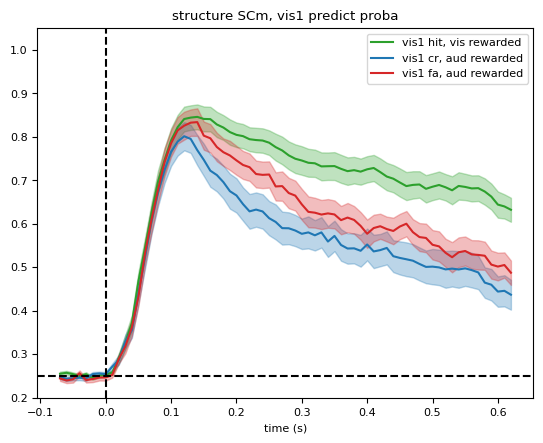

In [88]:
sel_structure='SCm'

fig,ax=plt.subplots(1,1)

timestamps=trial_type_table_df['bin_centers'].iloc[0].round(3)+.025

vis1_hit_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="vis1" and is_response==True and is_vis_rewarded==True')['predict_proba_vis1'].values)
vis1_cr_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="vis1" and is_response==False and is_vis_rewarded==False')['predict_proba_vis1'].values)
vis1_fa_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="vis1" and is_response==True and is_vis_rewarded==False')['predict_proba_vis1'].values)

vis1_hit_mean=np.nanmean(vis1_hit_values, axis=0)
vis1_cr_mean=np.nanmean(vis1_cr_values, axis=0)
vis1_fa_mean=np.nanmean(vis1_fa_values, axis=0)

vis1_hit_sem=stats.sem(vis1_hit_values, axis=0, nan_policy='omit')
vis1_cr_sem=stats.sem(vis1_cr_values, axis=0, nan_policy='omit')
vis1_fa_sem=stats.sem(vis1_fa_values, axis=0, nan_policy='omit')

ax.plot(timestamps, vis1_hit_mean, label='vis1 hit, vis rewarded', color='tab:green')
ax.fill_between(timestamps, vis1_hit_mean - vis1_hit_sem, vis1_hit_mean + vis1_hit_sem, color='tab:green', alpha=0.3)
ax.plot(timestamps, vis1_cr_mean, label='vis1 cr, aud rewarded', color='tab:blue')
ax.fill_between(timestamps, vis1_cr_mean - vis1_cr_sem, vis1_cr_mean + vis1_cr_sem, color='tab:blue', alpha=0.3)
ax.plot(timestamps, vis1_fa_mean, label='vis1 fa, aud rewarded', color='tab:red')
ax.fill_between(timestamps, vis1_fa_mean - vis1_fa_sem, vis1_fa_mean + vis1_fa_sem, color='tab:red', alpha=0.3)
ax.axhline(0.25, color='k', linestyle='--')
ax.axvline(0, color='k', linestyle='--')
ax.set_title(f'structure {sel_structure}, vis1 predict proba')
ax.set_xlabel('time (s)')
ax.set_ylim(0.2,1.05)
ax.legend()

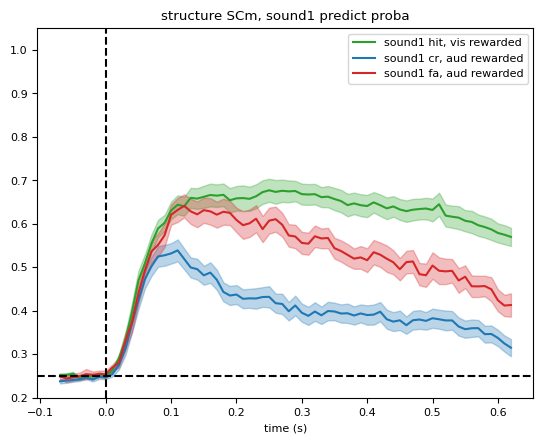

In [87]:
sel_structure='SCm'

fig,ax=plt.subplots(1,1)

timestamps=trial_type_table_df['bin_centers'].iloc[0].round(3)+.025

sound1_hit_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="sound1" and is_response==True and is_vis_rewarded==False')['predict_proba_sound1'].values)
sound1_cr_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="sound1" and is_response==False and is_vis_rewarded==True')['predict_proba_sound1'].values)
sound1_fa_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="sound1" and is_response==True and is_vis_rewarded==True')['predict_proba_sound1'].values)

sound1_hit_mean=np.nanmean(sound1_hit_values, axis=0)
sound1_cr_mean=np.nanmean(sound1_cr_values, axis=0)
sound1_fa_mean=np.nanmean(sound1_fa_values, axis=0)

sound1_hit_sem=stats.sem(sound1_hit_values, axis=0, nan_policy='omit')
sound1_cr_sem=stats.sem(sound1_cr_values, axis=0, nan_policy='omit')
sound1_fa_sem=stats.sem(sound1_fa_values, axis=0, nan_policy='omit')

ax.plot(timestamps, sound1_hit_mean, label='sound1 hit, vis rewarded', color='tab:green')
ax.fill_between(timestamps, sound1_hit_mean - sound1_hit_sem, sound1_hit_mean + sound1_hit_sem, color='tab:green', alpha=0.3)
ax.plot(timestamps, sound1_cr_mean, label='sound1 cr, aud rewarded', color='tab:blue')
ax.fill_between(timestamps, sound1_cr_mean - sound1_cr_sem, sound1_cr_mean + sound1_cr_sem, color='tab:blue', alpha=0.3)
ax.plot(timestamps, sound1_fa_mean, label='sound1 fa, aud rewarded', color='tab:red')
ax.fill_between(timestamps, sound1_fa_mean - sound1_fa_sem, sound1_fa_mean + sound1_fa_sem, color='tab:red', alpha=0.3)

ax.axhline(0.25, color='k', linestyle='--')
ax.axvline(0, color='k', linestyle='--')
ax.set_ylim(0.2,1.05)
ax.set_title(f'structure {sel_structure}, sound1 predict proba')
ax.set_xlabel('time (s)')
ax.legend()

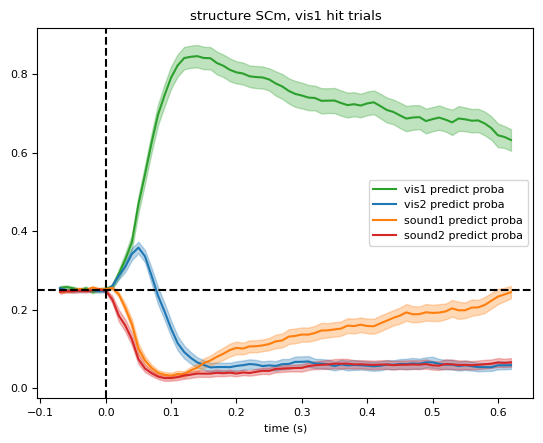

In [72]:
sel_structure='SCm'

fig,ax=plt.subplots(1,1)

timestamps=trial_type_table_df['bin_centers'].iloc[0].round(3)+.025

vis1_vis_hit_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="vis1" and is_response==True and is_vis_rewarded==True')['predict_proba_vis1'].values)
vis2_vis_hit_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="vis1" and is_response==True and is_vis_rewarded==True')['predict_proba_vis2'].values)
sound1_vis_hit_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="vis1" and is_response==True and is_vis_rewarded==True')['predict_proba_sound1'].values)
sound2_vis_hit_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="vis1" and is_response==True and is_vis_rewarded==True')['predict_proba_sound2'].values)

vis1_vis_hit_mean=np.nanmean(vis1_vis_hit_values, axis=0)
vis2_vis_hit_mean=np.nanmean(vis2_vis_hit_values, axis=0)
sound1_vis_hit_mean=np.nanmean(sound1_vis_hit_values, axis=0)
sound2_vis_hit_mean=np.nanmean(sound2_vis_hit_values, axis=0)

vis1_vis_hit_sem=stats.sem(vis1_vis_hit_values, axis=0, nan_policy='omit')
vis2_vis_hit_sem=stats.sem(vis2_vis_hit_values, axis=0, nan_policy='omit')
sound1_vis_hit_sem=stats.sem(sound1_vis_hit_values, axis=0, nan_policy='omit')
sound2_vis_hit_sem=stats.sem(sound2_vis_hit_values, axis=0, nan_policy='omit')

ax.plot(timestamps, vis1_vis_hit_mean, label='vis1 predict proba', color='tab:green')
ax.fill_between(timestamps, vis1_vis_hit_mean - vis1_vis_hit_sem, vis1_vis_hit_mean + vis1_vis_hit_sem, color='tab:green', alpha=0.3)
ax.plot(timestamps, vis2_vis_hit_mean, label='vis2 predict proba', color='tab:blue')
ax.fill_between(timestamps, vis2_vis_hit_mean - vis2_vis_hit_sem, vis2_vis_hit_mean + vis2_vis_hit_sem, color='tab:blue', alpha=0.3)
ax.plot(timestamps, sound1_vis_hit_mean, label='sound1 predict proba', color='tab:orange')
ax.fill_between(timestamps, sound1_vis_hit_mean - sound1_vis_hit_sem, sound1_vis_hit_mean + sound1_vis_hit_sem, color='tab:orange', alpha=0.3)
ax.plot(timestamps, sound2_vis_hit_mean, label='sound2 predict proba', color='tab:red')   
ax.fill_between(timestamps, sound2_vis_hit_mean - sound2_vis_hit_sem, sound2_vis_hit_mean + sound2_vis_hit_sem, color='tab:red', alpha=0.3)

ax.axhline(0.25, color='k', linestyle='--')
ax.axvline(0, color='k', linestyle='--')
ax.set_title(f'structure {sel_structure}, vis1 hit trials')
ax.set_xlabel('time (s)')
ax.legend()

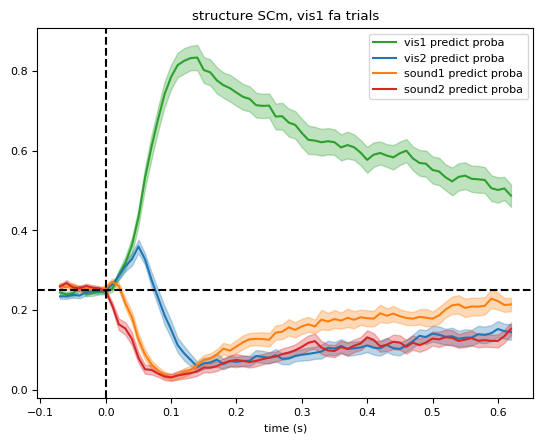

In [71]:
sel_structure='SCm'

fig,ax=plt.subplots(1,1)

timestamps=trial_type_table_df['bin_centers'].iloc[0].round(3)+.025

vis1_vis_hit_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="vis1" and is_response==True and is_vis_rewarded==False')['predict_proba_vis1'])
vis2_vis_hit_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="vis1" and is_response==True and is_vis_rewarded==False')['predict_proba_vis2'])
sound1_vis_hit_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="vis1" and is_response==True and is_vis_rewarded==False')['predict_proba_sound1'])
sound2_vis_hit_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="vis1" and is_response==True and is_vis_rewarded==False')['predict_proba_sound2'])

vis1_vis_hit_mean=np.nanmean(vis1_vis_hit_values, axis=0)
vis2_vis_hit_mean=np.nanmean(vis2_vis_hit_values, axis=0)
sound1_vis_hit_mean=np.nanmean(sound1_vis_hit_values, axis=0)
sound2_vis_hit_mean=np.nanmean(sound2_vis_hit_values, axis=0)

vis1_vis_hit_sem=stats.sem(vis1_vis_hit_values, axis=0, nan_policy='omit')
vis2_vis_hit_sem=stats.sem(vis2_vis_hit_values, axis=0, nan_policy='omit')
sound1_vis_hit_sem=stats.sem(sound1_vis_hit_values, axis=0, nan_policy='omit')
sound2_vis_hit_sem=stats.sem(sound2_vis_hit_values, axis=0, nan_policy='omit')

ax.plot(timestamps, vis1_vis_hit_mean, label='vis1 predict proba', color='tab:green')
ax.fill_between(timestamps, vis1_vis_hit_mean - vis1_vis_hit_sem, vis1_vis_hit_mean + vis1_vis_hit_sem, color='tab:green', alpha=0.3)
ax.plot(timestamps, vis2_vis_hit_mean, label='vis2 predict proba', color='tab:blue')
ax.fill_between(timestamps, vis2_vis_hit_mean - vis2_vis_hit_sem, vis2_vis_hit_mean + vis2_vis_hit_sem, color='tab:blue', alpha=0.3)
ax.plot(timestamps, sound1_vis_hit_mean, label='sound1 predict proba', color='tab:orange')
ax.fill_between(timestamps, sound1_vis_hit_mean - sound1_vis_hit_sem, sound1_vis_hit_mean + sound1_vis_hit_sem, color='tab:orange', alpha=0.3)
ax.plot(timestamps, sound2_vis_hit_mean, label='sound2 predict proba', color='tab:red')   
ax.fill_between(timestamps, sound2_vis_hit_mean - sound2_vis_hit_sem, sound2_vis_hit_mean + sound2_vis_hit_sem, color='tab:red', alpha=0.3)

ax.axhline(0.25, color='k', linestyle='--')
ax.axvline(0, color='k', linestyle='--')
ax.set_title(f'structure {sel_structure}, vis1 fa trials')
ax.set_xlabel('time (s)')
ax.legend()

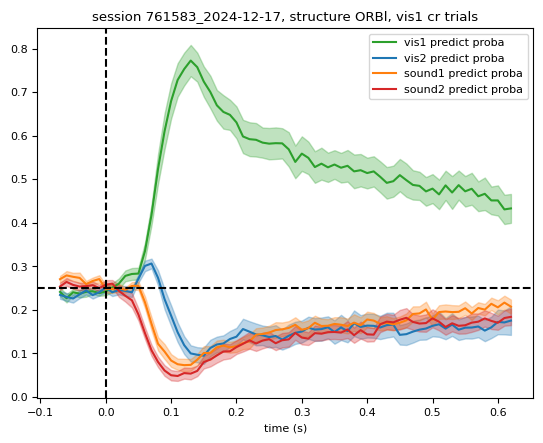

In [70]:
sel_structure='ORBl'

fig,ax=plt.subplots(1,1)

timestamps=trial_type_table_df['bin_centers'].iloc[0].round(3)+.025

vis1_vis_hit_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="vis1" and is_response==False and is_vis_rewarded==False')['predict_proba_vis1'])
vis2_vis_hit_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="vis1" and is_response==False and is_vis_rewarded==False')['predict_proba_vis2'])
sound1_vis_hit_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="vis1" and is_response==False and is_vis_rewarded==False')['predict_proba_sound1'])
sound2_vis_hit_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="vis1" and is_response==False and is_vis_rewarded==False')['predict_proba_sound2'])

vis1_vis_hit_mean=np.nanmean(vis1_vis_hit_values, axis=0)
vis2_vis_hit_mean=np.nanmean(vis2_vis_hit_values, axis=0)
sound1_vis_hit_mean=np.nanmean(sound1_vis_hit_values, axis=0)
sound2_vis_hit_mean=np.nanmean(sound2_vis_hit_values, axis=0)

vis1_vis_hit_sem=stats.sem(vis1_vis_hit_values, axis=0, nan_policy='omit')
vis2_vis_hit_sem=stats.sem(vis2_vis_hit_values, axis=0, nan_policy='omit')
sound1_vis_hit_sem=stats.sem(sound1_vis_hit_values, axis=0, nan_policy='omit')
sound2_vis_hit_sem=stats.sem(sound2_vis_hit_values, axis=0, nan_policy='omit')

ax.plot(timestamps, vis1_vis_hit_mean, label='vis1 predict proba', color='tab:green')
ax.fill_between(timestamps, vis1_vis_hit_mean - vis1_vis_hit_sem, vis1_vis_hit_mean + vis1_vis_hit_sem, color='tab:green', alpha=0.3)
ax.plot(timestamps, vis2_vis_hit_mean, label='vis2 predict proba', color='tab:blue')
ax.fill_between(timestamps, vis2_vis_hit_mean - vis2_vis_hit_sem, vis2_vis_hit_mean + vis2_vis_hit_sem, color='tab:blue', alpha=0.3)
ax.plot(timestamps, sound1_vis_hit_mean, label='sound1 predict proba', color='tab:orange')
ax.fill_between(timestamps, sound1_vis_hit_mean - sound1_vis_hit_sem, sound1_vis_hit_mean + sound1_vis_hit_sem, color='tab:orange', alpha=0.3)
ax.plot(timestamps, sound2_vis_hit_mean, label='sound2 predict proba', color='tab:red')   
ax.fill_between(timestamps, sound2_vis_hit_mean - sound2_vis_hit_sem, sound2_vis_hit_mean + sound2_vis_hit_sem, color='tab:red', alpha=0.3)

ax.axhline(0.25, color='k', linestyle='--')
ax.axvline(0, color='k', linestyle='--')
ax.set_title(f'session {sel_session}, structure {sel_structure}, vis1 cr trials')
ax.set_xlabel('time (s)')
ax.legend()

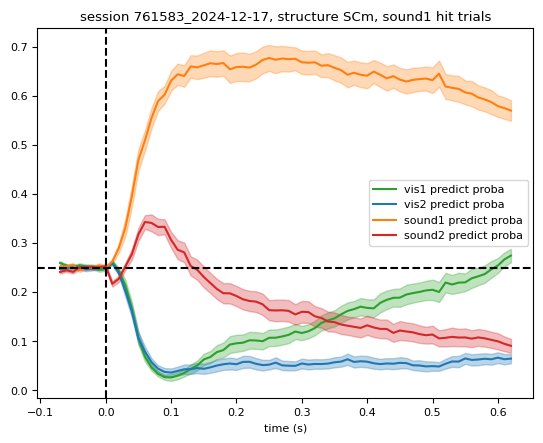

In [69]:
sel_structure='SCm'

fig,ax=plt.subplots(1,1)

timestamps=trial_type_table_df['bin_centers'].iloc[0].round(3)+0.025

vis1_aud_hit_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="sound1" and is_response==True and is_vis_rewarded==False')['predict_proba_vis1'])
vis2_aud_hit_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="sound1" and is_response==True and is_vis_rewarded==False')['predict_proba_vis2'])
sound1_aud_hit_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="sound1" and is_response==True and is_vis_rewarded==False')['predict_proba_sound1'])
sound2_aud_hit_values=np.vstack(trial_type_table_df.query('structure==@sel_structure and stim_name=="sound1" and is_response==True and is_vis_rewarded==False')['predict_proba_sound2'])

vis1_aud_hit_mean=np.nanmean(vis1_aud_hit_values, axis=0)
vis2_aud_hit_mean=np.nanmean(vis2_aud_hit_values, axis=0)
sound1_aud_hit_mean=np.nanmean(sound1_aud_hit_values, axis=0)
sound2_aud_hit_mean=np.nanmean(sound2_aud_hit_values, axis=0)

vis1_aud_hit_sem=stats.sem(vis1_aud_hit_values, axis=0, nan_policy='omit')
vis2_aud_hit_sem=stats.sem(vis2_aud_hit_values, axis=0, nan_policy='omit')
sound1_aud_hit_sem=stats.sem(sound1_aud_hit_values, axis=0, nan_policy='omit')
sound2_aud_hit_sem=stats.sem(sound2_aud_hit_values, axis=0, nan_policy='omit')

ax.plot(timestamps, vis1_aud_hit_mean, label='vis1 predict proba', color='tab:green')
ax.fill_between(timestamps, vis1_aud_hit_mean - vis1_aud_hit_sem, vis1_aud_hit_mean + vis1_aud_hit_sem, color='tab:green', alpha=0.3)
ax.plot(timestamps, vis2_aud_hit_mean, label='vis2 predict proba', color='tab:blue')
ax.fill_between(timestamps, vis2_aud_hit_mean - vis2_aud_hit_sem, vis2_aud_hit_mean + vis2_aud_hit_sem, color='tab:blue', alpha=0.3)
ax.plot(timestamps, sound1_aud_hit_mean, label='sound1 predict proba', color='tab:orange')
ax.fill_between(timestamps, sound1_aud_hit_mean - sound1_aud_hit_sem, sound1_aud_hit_mean + sound1_aud_hit_sem, color='tab:orange', alpha=0.3)
ax.plot(timestamps, sound2_aud_hit_mean, label='sound2 predict proba', color='tab:red')   
ax.fill_between(timestamps, sound2_aud_hit_mean - sound2_aud_hit_sem, sound2_aud_hit_mean + sound2_aud_hit_sem, color='tab:red', alpha=0.3)  

ax.axhline(0.25, color='k', linestyle='--')
ax.axvline(0, color='k', linestyle='--')
ax.set_title(f'session {sel_session}, structure {sel_structure}, sound1 hit trials')
ax.set_xlabel('time (s)')
ax.legend()